In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
df_egrid = pd.read_excel('egrid2022_data.xlsx', sheet_name='PLNT22', skiprows=1)
cols = ['ORISPL','BACODE','PLCO2AN','PLNGENAN', 'PLCO2RTA', 'NAMEPCAP','PLFUELCT',
        'PLNOXAN', 'PLNOXRTA', 'PLSO2AN', 'PLSO2RTA']
df_egrid = df_egrid[cols]
df_egrid.dropna(inplace=True)
fossil_fuels = ['COAL','GAS','OIL']
df_egrid = df_egrid.loc[df_egrid.PLFUELCT.isin(fossil_fuels)]

In [89]:
df_egrid['PLSO2RTA'].describe()

count    2597.000000
mean        2.129731
std        17.253921
min         0.000000
25%         0.006000
50%         0.028000
75%         1.700000
max       626.000000
Name: PLSO2RTA, dtype: float64

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_72377/495409343.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


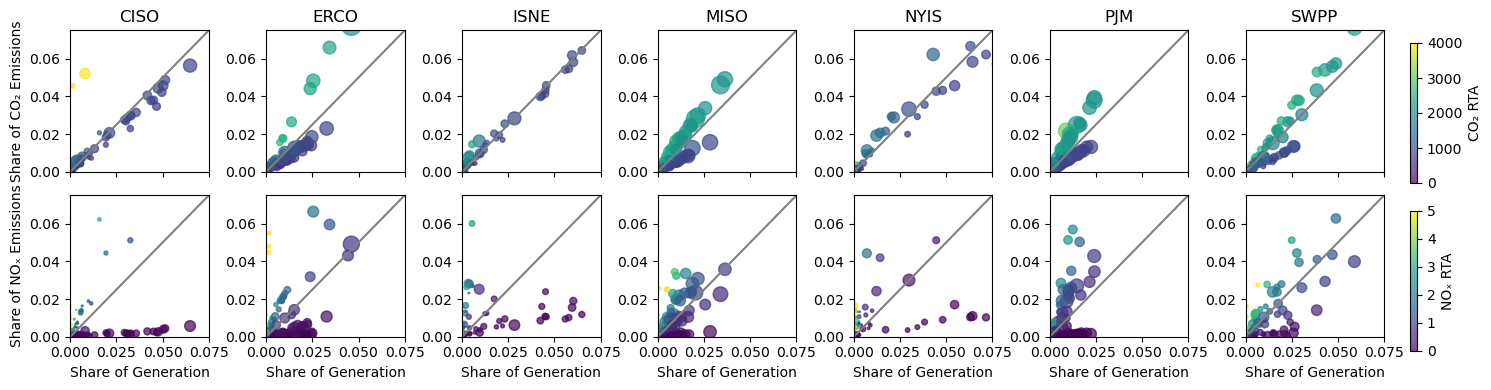

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter data (use your actual DataFrame here)
df = df_egrid.copy()
bas_of_interest = ['CISO', 'ERCO', 'ISNE', 'MISO', 'NYIS', 'PJM', 'SWPP']
df = df[df['BACODE'].isin(bas_of_interest)]

# Calculate total generation and CO2/NOx emissions for each BA
ba_totals = df.groupby('BACODE')[['PLCO2AN', 'PLNOXAN', 'PLNGENAN']].sum().rename(
    columns={'PLCO2AN': 'BA_CO2', 'PLNOXAN': 'BA_NOX', 'PLNGENAN': 'BA_GEN'})
df = df.merge(ba_totals, on='BACODE')

# Calculate shares for both CO2 and NOx
df['gen_share'] = df['PLNGENAN'] / df['BA_GEN']
df['co2_emissions_share'] = df['PLCO2AN'] / df['BA_CO2']
df['nox_emissions_share'] = df['PLNOXAN'] / df['BA_NOX']

# Set explicit color ranges
co2_vmin, co2_vmax = 0, 4000
nox_vmin, nox_vmax = 0, 5  # Adjust these values based on your NOx data range

# Set up a grid of square subplots (2 rows)
fig, axs = plt.subplots(2, 8, figsize=(16, 4), sharex='col')
axs = axs.reshape(2, 8)

# Plot each specified BA's data on separate subplots
for i, ba in enumerate(bas_of_interest):
    ba_data = df[df['BACODE'] == ba]
    
    # CO2 plot (top row)
    scatter_co2 = axs[0, i].scatter(
        ba_data['gen_share'], 
        ba_data['co2_emissions_share'], 
        c=ba_data['PLCO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='viridis',
        alpha=0.7,
        vmin=co2_vmin,
        vmax=co2_vmax
    )
    
    axs[0, i].plot([0, 1], [0, 1], transform=axs[0, i].transAxes, color='gray')
    axs[0, i].set_title(f'{ba}')
    axs[0, i].set_ylim(0, 0.075)
    
    # NOx plot (bottom row)
    scatter_nox = axs[1, i].scatter(
        ba_data['gen_share'], 
        ba_data['nox_emissions_share'], 
        c=ba_data['PLNOXRTA'],
        s=ba_data['NAMEPCAP'] / 30,
        cmap='viridis',
        alpha=0.7,
        vmin=nox_vmin,
        vmax=nox_vmax
    )
    
    axs[1, i].plot([0, 1], [0, 1], transform=axs[1, i].transAxes, color='gray')
    axs[1, i].set_xlim(0, 0.075)
    axs[1, i].set_ylim(0, 0.075)

# Set labels
for ax in axs[0]:
    ax.set_xlabel('')
for ax in axs[1]:
    ax.set_xlabel('Share of Generation')

axs[0, 0].set_ylabel('Share of CO₂ Emissions')
axs[1, 0].set_ylabel('Share of NOₓ Emissions')

# Remove the extra subplots
fig.delaxes(axs[0, -1])
fig.delaxes(axs[1, -1])

# Add colorbars
cbar_co2 = fig.colorbar(scatter_co2, ax=axs[0], orientation='vertical', fraction=0.02, pad=0.04)
cbar_co2.set_label('CO₂ RTA')

cbar_nox = fig.colorbar(scatter_nox, ax=axs[1], orientation='vertical', fraction=0.02, pad=0.04)
cbar_nox.set_label('NOₓ RTA')

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_72377/3881902355.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])


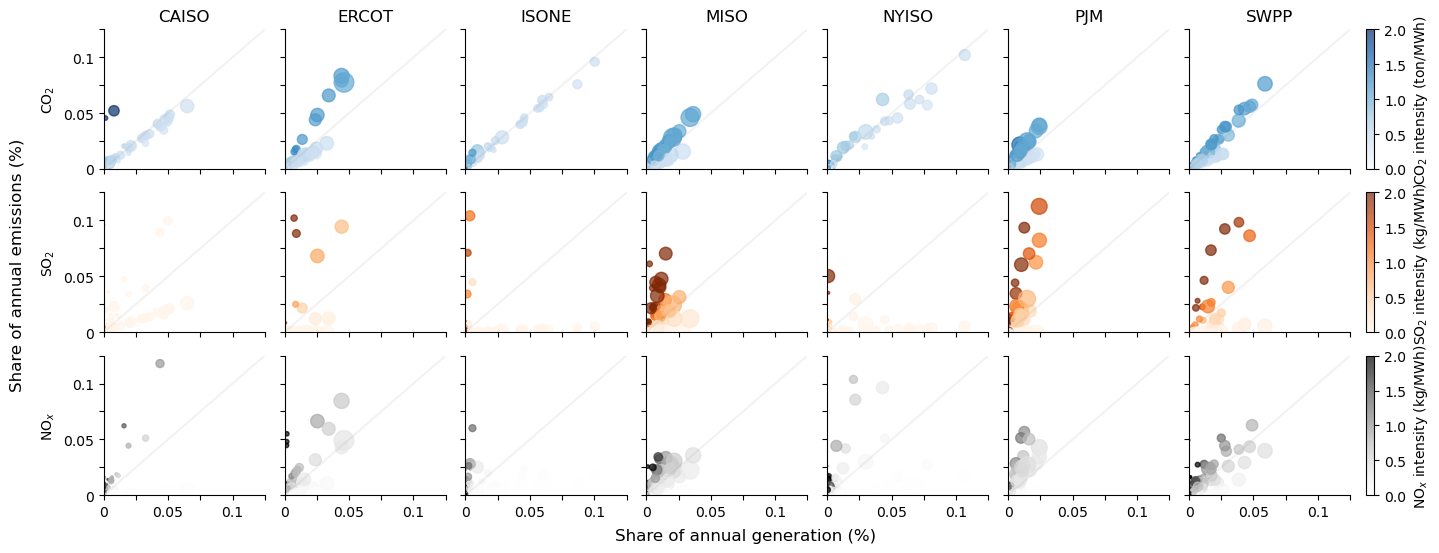

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors

# Set explicit color ranges for each pollutant
co2_vmin, co2_vmax = 0, 2  # CO2 intensity in tons/MWh
so2_vmin, so2_vmax = 0, 2  # SO2 intensity in kg/MWh
nox_vmin, nox_vmax = 0, 2  # NOx intensity in kg/MWh

# Load and filter data
df = df_egrid.copy()
bas_of_interest = ['CISO', 'ERCO', 'ISNE', 'MISO', 'NYIS', 'PJM', 'SWPP']
ba_names = {'CISO': 'CAISO', 'ERCO': 'ERCOT', 'ISNE': 'ISONE', 'MISO': 'MISO', 
            'NYIS': 'NYISO', 'PJM': 'PJM', 'SWPP': 'SWPP'}
df = df[df['BACODE'].isin(bas_of_interest)]

# Calculate total generation and emissions for each BA
ba_totals = df.groupby('BACODE')[['PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'PLNGENAN']].sum().rename(
    columns={'PLCO2AN': 'BA_CO2', 'PLNOXAN': 'BA_NOX', 'PLSO2AN': 'BA_SO2', 'PLNGENAN': 'BA_GEN'})
df = df.merge(ba_totals, on='BACODE')

# Calculate shares for all pollutants
df['gen_share'] = df['PLNGENAN'] / df['BA_GEN']
df['co2_emissions_share'] = df['PLCO2AN'] / df['BA_CO2']
df['nox_emissions_share'] = df['PLNOXAN'] / df['BA_NOX']
df['so2_emissions_share'] = df['PLSO2AN'] / df['BA_SO2']

# Convert RTAs
df['PLCO2RTA'] = df['PLCO2RTA'] / 2000  # lb/MWh to ton/MWh
df['PLSO2RTA'] = df['PLSO2RTA'] * 0.453592  # lb/MWh to kg/MWh
df['PLNOXRTA'] = df['PLNOXRTA'] * 0.453592  # lb/MWh to kg/MWh

# Set up a grid of square subplots (3 rows)
fig, axs = plt.subplots(3, 8, figsize=(16, 6), sharex='col', sharey='row')
axs = axs.reshape(3, 8)

# Define x-tick labels for consistent formatting across rows
xticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
xtick_labels = ['0', '', '0.05', '', '0.1', '']

# Define y-ticks
yticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
ytick_labels = ['0', '', '0.05', '', '0.1', '']

for i, ba in enumerate(bas_of_interest):
    ba_data = df[df['BACODE'] == ba]
    
    # CO2 plot (top row) with SUB color scheme
    scatter_co2 = axs[0, i].scatter(
        ba_data['gen_share'], 
        ba_data['co2_emissions_share'], 
        c=ba_data['PLCO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Blues',
        alpha=0.7,
        vmin=co2_vmin,
        vmax=co2_vmax
    )
    
    # SO2 plot (middle row) with BIT color scheme
    scatter_so2 = axs[1, i].scatter(
        ba_data['gen_share'], 
        ba_data['so2_emissions_share'], 
        c=ba_data['PLSO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Oranges',
        alpha=0.7,
        vmin=so2_vmin,
        vmax=so2_vmax
    )
    
    # NOx plot (bottom row) with Other color scheme
    scatter_nox = axs[2, i].scatter(
        ba_data['gen_share'], 
        ba_data['nox_emissions_share'], 
        c=ba_data['PLNOXRTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Greys',
        alpha=0.7,
        vmin=nox_vmin,
        vmax=nox_vmax
    )
    
    # Set limits and add diagonal lines for all plots
    for row in range(3):
        axs[row, i].plot([0, 1], [0, 1], transform=axs[row, i].transAxes, color='gray', alpha=0.1)
        axs[row, i].set_xlim(0, 0.125)
        axs[row, i].set_ylim(0, 0.125)
        axs[row, i].set_xticks(xticks)
        axs[row, i].set_yticks(yticks)
        axs[row, i].set_yticklabels(ytick_labels)
        
        # Set x-tick labels only on the bottom row
        if row == 2:
            axs[row, i].set_xticklabels(xtick_labels)

        axs[row, i].spines['right'].set_visible(False)
        axs[row, i].spines['top'].set_visible(False)
    
    axs[0, i].set_title(ba_names[ba])

# Set labels
axs[0, 0].set_ylabel('CO$_2$')
axs[1, 0].set_ylabel('SO$_2$')
axs[2, 0].set_ylabel('NO$_x$')

# Add master labels with adjusted positions and font size
fig.text(0.04, 0.5, 'Share of annual emissions (%)', va='center', rotation='vertical', fontsize=plt.gca().title.get_fontsize())
fig.text(0.5, 0.04, 'Share of annual generation (%)', ha='center', fontsize=plt.gca().title.get_fontsize())

# Remove the extra subplots
fig.delaxes(axs[0, -1])
fig.delaxes(axs[1, -1])
fig.delaxes(axs[2, -1])

# Add colorbars with custom colormaps
cax_co2 = inset_axes(axs[0, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[0, 6].transAxes, borderpad=0)
cbar_co2 = fig.colorbar(scatter_co2, cax=cax_co2, orientation='vertical')
cbar_co2.set_label('CO$_2$ intensity (ton/MWh)')

cax_so2 = inset_axes(axs[1, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[1, 6].transAxes, borderpad=0)
cbar_so2 = fig.colorbar(scatter_so2, cax=cax_so2, orientation='vertical')
cbar_so2.set_label('SO$_2$ intensity (kg/MWh)')

cax_nox = inset_axes(axs[2, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[2, 6].transAxes, borderpad=0)
cbar_nox = fig.colorbar(scatter_nox, cax=cax_nox, orientation='vertical')
cbar_nox.set_label('NO$_x$ intensity (kg/MWh)')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_72377/3881902355.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])


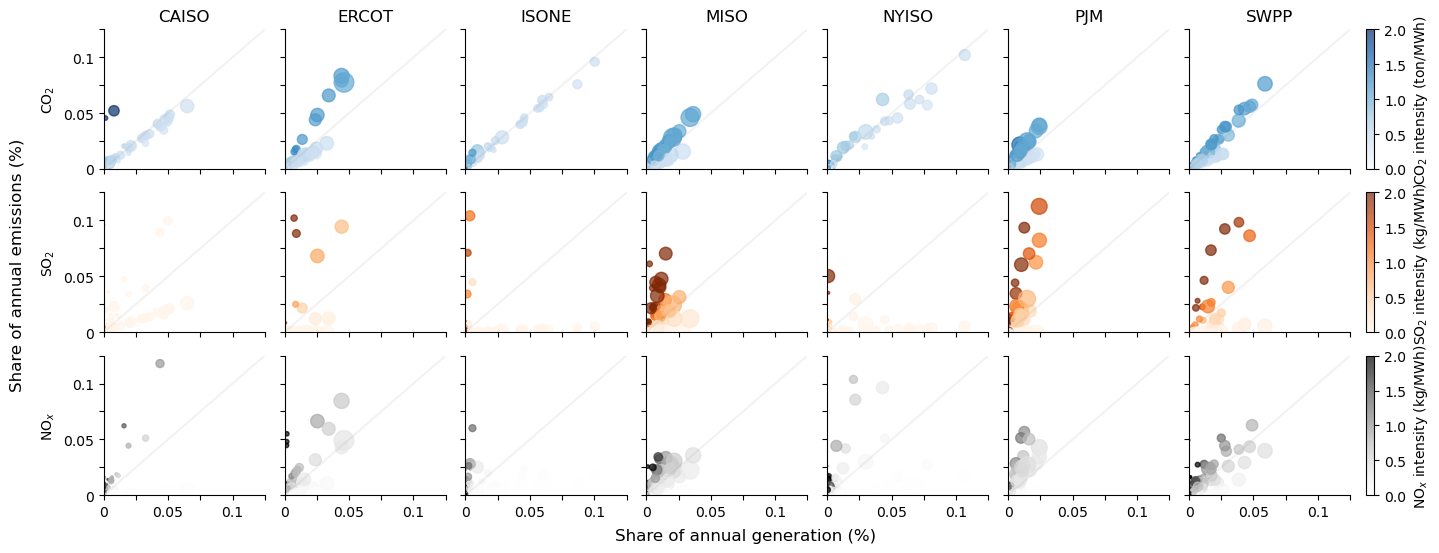

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors

# Set explicit color ranges for each pollutant
co2_vmin, co2_vmax = 0, 2  # CO2 intensity in tons/MWh
so2_vmin, so2_vmax = 0, 2  # SO2 intensity in kg/MWh
nox_vmin, nox_vmax = 0, 2  # NOx intensity in kg/MWh

# Load and filter data
df = df_egrid.copy()
bas_of_interest = ['CISO', 'ERCO', 'ISNE', 'MISO', 'NYIS', 'PJM', 'SWPP']
ba_names = {'CISO': 'CAISO', 'ERCO': 'ERCOT', 'ISNE': 'ISONE', 'MISO': 'MISO', 
            'NYIS': 'NYISO', 'PJM': 'PJM', 'SWPP': 'SWPP'}
df = df[df['BACODE'].isin(bas_of_interest)]

# Calculate total generation and emissions for each BA
ba_totals = df.groupby('BACODE')[['PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'PLNGENAN']].sum().rename(
    columns={'PLCO2AN': 'BA_CO2', 'PLNOXAN': 'BA_NOX', 'PLSO2AN': 'BA_SO2', 'PLNGENAN': 'BA_GEN'})
df = df.merge(ba_totals, on='BACODE')

# Calculate shares for all pollutants
df['gen_share'] = df['PLNGENAN'] / df['BA_GEN']
df['co2_emissions_share'] = df['PLCO2AN'] / df['BA_CO2']
df['nox_emissions_share'] = df['PLNOXAN'] / df['BA_NOX']
df['so2_emissions_share'] = df['PLSO2AN'] / df['BA_SO2']

# Convert RTAs
df['PLCO2RTA'] = df['PLCO2RTA'] / 2000  # lb/MWh to ton/MWh
df['PLSO2RTA'] = df['PLSO2RTA'] * 0.453592  # lb/MWh to kg/MWh
df['PLNOXRTA'] = df['PLNOXRTA'] * 0.453592  # lb/MWh to kg/MWh

# Set up a grid of square subplots (3 rows)
fig, axs = plt.subplots(3, 8, figsize=(16, 6), sharex='col', sharey='row')
axs = axs.reshape(3, 8)

# Define x-tick labels for consistent formatting across rows
xticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
xtick_labels = ['0', '', '0.05', '', '0.1', '']

# Define y-ticks
yticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
ytick_labels = ['0', '', '0.05', '', '0.1', '']

for i, ba in enumerate(bas_of_interest):
    ba_data = df[df['BACODE'] == ba]
    
    # CO2 plot (top row) with SUB color scheme
    scatter_co2 = axs[0, i].scatter(
        ba_data['gen_share'], 
        ba_data['co2_emissions_share'], 
        c=ba_data['PLCO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Blues',
        alpha=0.7,
        vmin=co2_vmin,
        vmax=co2_vmax
    )
    
    # SO2 plot (middle row) with BIT color scheme
    scatter_so2 = axs[1, i].scatter(
        ba_data['gen_share'], 
        ba_data['so2_emissions_share'], 
        c=ba_data['PLSO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Oranges',
        alpha=0.7,
        vmin=so2_vmin,
        vmax=so2_vmax
    )
    
    # NOx plot (bottom row) with Other color scheme
    scatter_nox = axs[2, i].scatter(
        ba_data['gen_share'], 
        ba_data['nox_emissions_share'], 
        c=ba_data['PLNOXRTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Greys',
        alpha=0.7,
        vmin=nox_vmin,
        vmax=nox_vmax
    )
    
    # Set limits and add diagonal lines for all plots
    for row in range(3):
        axs[row, i].plot([0, 1], [0, 1], transform=axs[row, i].transAxes, color='gray', alpha=0.1)
        axs[row, i].set_xlim(0, 0.125)
        axs[row, i].set_ylim(0, 0.125)
        axs[row, i].set_xticks(xticks)
        axs[row, i].set_yticks(yticks)
        axs[row, i].set_yticklabels(ytick_labels)
        
        # Set x-tick labels only on the bottom row
        if row == 2:
            axs[row, i].set_xticklabels(xtick_labels)

        axs[row, i].spines['right'].set_visible(False)
        axs[row, i].spines['top'].set_visible(False)
    
    axs[0, i].set_title(ba_names[ba])

# Set labels
axs[0, 0].set_ylabel('CO$_2$')
axs[1, 0].set_ylabel('SO$_2$')
axs[2, 0].set_ylabel('NO$_x$')

# Add master labels with adjusted positions and font size
fig.text(0.04, 0.5, 'Share of annual emissions (%)', va='center', rotation='vertical', fontsize=plt.gca().title.get_fontsize())
fig.text(0.5, 0.04, 'Share of annual generation (%)', ha='center', fontsize=plt.gca().title.get_fontsize())

# Remove the extra subplots
fig.delaxes(axs[0, -1])
fig.delaxes(axs[1, -1])
fig.delaxes(axs[2, -1])

# Add colorbars with custom colormaps
cax_co2 = inset_axes(axs[0, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[0, 6].transAxes, borderpad=0)
cbar_co2 = fig.colorbar(scatter_co2, cax=cax_co2, orientation='vertical')
cbar_co2.set_label('CO$_2$ intensity (ton/MWh)')

cax_so2 = inset_axes(axs[1, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[1, 6].transAxes, borderpad=0)
cbar_so2 = fig.colorbar(scatter_so2, cax=cax_so2, orientation='vertical')
cbar_so2.set_label('SO$_2$ intensity (kg/MWh)')

cax_nox = inset_axes(axs[2, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[2, 6].transAxes, borderpad=0)
cbar_nox = fig.colorbar(scatter_nox, cax=cax_nox, orientation='vertical')
cbar_nox.set_label('NO$_x$ intensity (kg/MWh)')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_72377/3254785400.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])


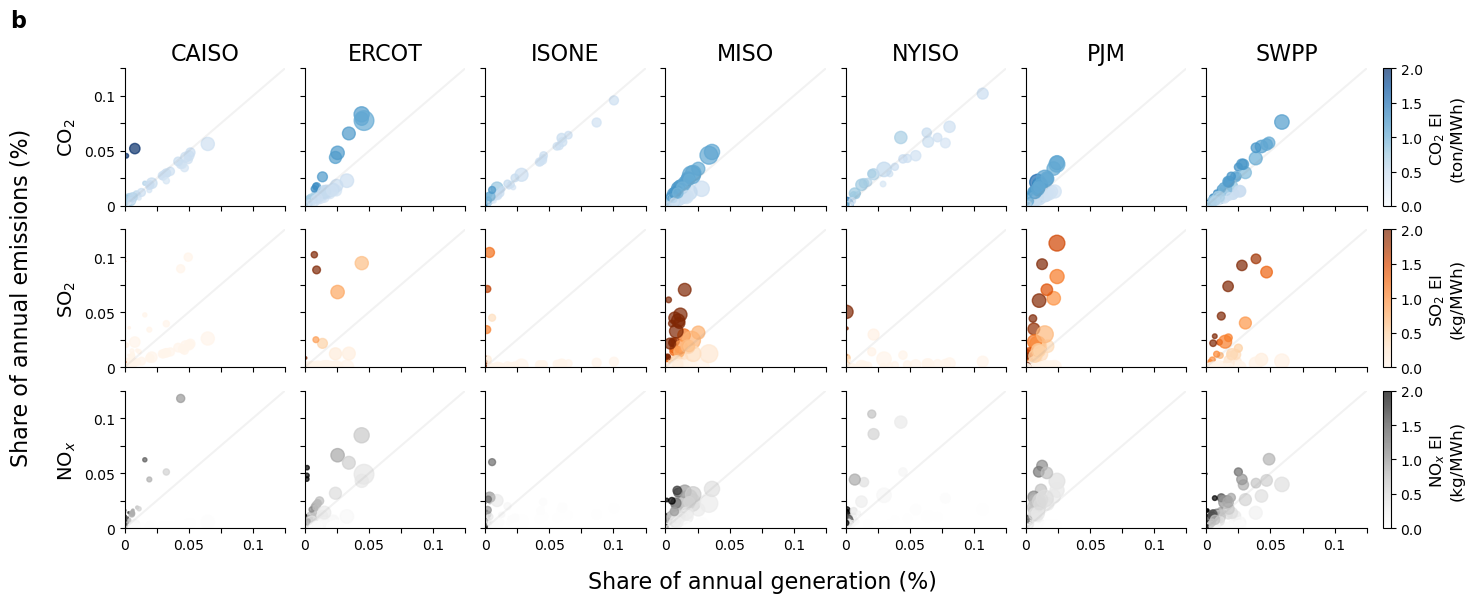

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors

# Set explicit color ranges for each pollutant
co2_vmin, co2_vmax = 0, 2  # CO2 intensity in tons/MWh
so2_vmin, so2_vmax = 0, 2  # SO2 intensity in kg/MWh
nox_vmin, nox_vmax = 0, 2  # NOx intensity in kg/MWh

# Load and filter data
df = df_egrid.copy()
bas_of_interest = ['CISO', 'ERCO', 'ISNE', 'MISO', 'NYIS', 'PJM', 'SWPP']
ba_names = {'CISO': 'CAISO', 'ERCO': 'ERCOT', 'ISNE': 'ISONE', 'MISO': 'MISO', 
            'NYIS': 'NYISO', 'PJM': 'PJM', 'SWPP': 'SWPP'}
df = df[df['BACODE'].isin(bas_of_interest)]

# Calculate total generation and emissions for each BA
ba_totals = df.groupby('BACODE')[['PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'PLNGENAN']].sum().rename(
    columns={'PLCO2AN': 'BA_CO2', 'PLNOXAN': 'BA_NOX', 'PLSO2AN': 'BA_SO2', 'PLNGENAN': 'BA_GEN'})
df = df.merge(ba_totals, on='BACODE')

# Calculate shares for all pollutants
df['gen_share'] = df['PLNGENAN'] / df['BA_GEN']
df['co2_emissions_share'] = df['PLCO2AN'] / df['BA_CO2']
df['nox_emissions_share'] = df['PLNOXAN'] / df['BA_NOX']
df['so2_emissions_share'] = df['PLSO2AN'] / df['BA_SO2']

# Convert RTAs
df['PLCO2RTA'] = df['PLCO2RTA'] / 2000  # lb/MWh to ton/MWh
df['PLSO2RTA'] = df['PLSO2RTA'] * 0.453592  # lb/MWh to kg/MWh
df['PLNOXRTA'] = df['PLNOXRTA'] * 0.453592  # lb/MWh to kg/MWh

# Set up a grid of square subplots (3 rows)
fig, axs = plt.subplots(3, 8, figsize=(16, 6), sharex='col', sharey='row')
axs = axs.reshape(3, 8)

# Define x-tick labels for consistent formatting across rows
xticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
xtick_labels = ['0', '', '0.05', '', '0.1', '']

# Define y-ticks
yticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
ytick_labels = ['0', '', '0.05', '', '0.1', '']

for i, ba in enumerate(bas_of_interest):
    ba_data = df[df['BACODE'] == ba]
    
    # CO2 plot (top row) with SUB color scheme
    scatter_co2 = axs[0, i].scatter(
        ba_data['gen_share'], 
        ba_data['co2_emissions_share'], 
        c=ba_data['PLCO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Blues',
        alpha=0.7,
        vmin=co2_vmin,
        vmax=co2_vmax
    )
    
    # SO2 plot (middle row) with BIT color scheme
    scatter_so2 = axs[1, i].scatter(
        ba_data['gen_share'], 
        ba_data['so2_emissions_share'], 
        c=ba_data['PLSO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Oranges',
        alpha=0.7,
        vmin=so2_vmin,
        vmax=so2_vmax
    )
    
    # NOx plot (bottom row) with Other color scheme
    scatter_nox = axs[2, i].scatter(
        ba_data['gen_share'], 
        ba_data['nox_emissions_share'], 
        c=ba_data['PLNOXRTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Greys',
        alpha=0.7,
        vmin=nox_vmin,
        vmax=nox_vmax
    )
    
    # Set limits and add diagonal lines for all plots
    for row in range(3):
        axs[row, i].plot([0, 1], [0, 1], transform=axs[row, i].transAxes, color='gray', alpha=0.1)
        axs[row, i].set_xlim(0, 0.125)
        axs[row, i].set_ylim(0, 0.125)
        axs[row, i].set_xticks(xticks)
        axs[row, i].set_yticks(yticks)
        axs[row, i].set_yticklabels(ytick_labels)
        
        # Set x-tick labels only on the bottom row
        if row == 2:
            axs[row, i].set_xticklabels(xtick_labels)

        axs[row, i].spines['right'].set_visible(False)
        axs[row, i].spines['top'].set_visible(False)
    
    axs[0, i].set_title(ba_names[ba], fontsize=16)

# Set labels
axs[0, 0].set_ylabel('CO$_2$', fontsize=14)
axs[1, 0].set_ylabel('SO$_2$', fontsize=14)
axs[2, 0].set_ylabel('NO$_x$', fontsize=14)

# Add master labels with padding
fig.text(0.03, 0.5, 'Share of annual emissions (%)', va='center', rotation='vertical', fontsize=16)  # Move slightly left
fig.text(0.5, 0.015, 'Share of annual generation (%)', ha='center', fontsize=16)  # Move slightly down

# Remove the extra subplots
fig.delaxes(axs[0, -1])
fig.delaxes(axs[1, -1])
fig.delaxes(axs[2, -1])

# Add colorbars with custom colormaps
cax_co2 = inset_axes(axs[0, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[0, 6].transAxes, borderpad=0)
cbar_co2 = fig.colorbar(scatter_co2, cax=cax_co2, orientation='vertical')
cbar_co2.set_label('CO$_2$ EI \n(ton/MWh)', fontsize=12)

cax_so2 = inset_axes(axs[1, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[1, 6].transAxes, borderpad=0)
cbar_so2 = fig.colorbar(scatter_so2, cax=cax_so2, orientation='vertical')
cbar_so2.set_label('SO$_2$ EI \n(kg/MWh)', fontsize=12)

cax_nox = inset_axes(axs[2, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[2, 6].transAxes, borderpad=0)
cbar_nox = fig.colorbar(scatter_nox, cax=cax_nox, orientation='vertical')
cbar_nox.set_label('NO$_x$ EI \n(kg/MWh)', fontsize=12)

# Add lowercase bold 'b' in the top left corner
fig.text(0.03, 0.98, 'b', fontsize=16, fontweight='bold', ha='left', va='top')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_72377/3881902355.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])


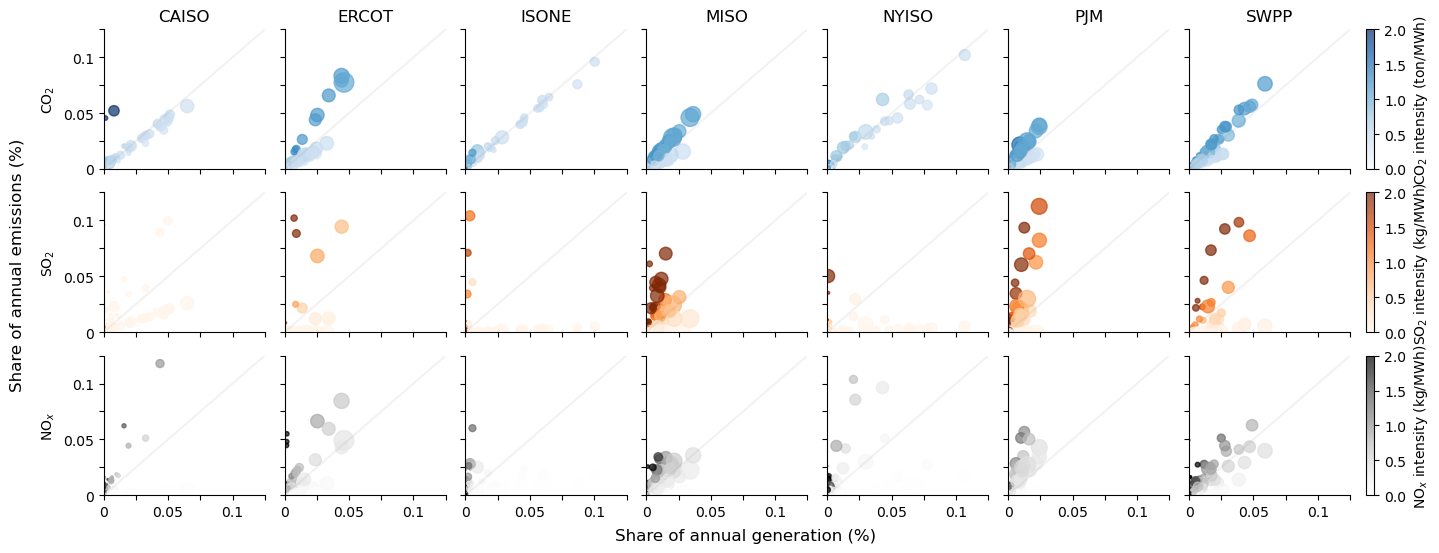

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors

# Set explicit color ranges for each pollutant
co2_vmin, co2_vmax = 0, 2  # CO2 intensity in tons/MWh
so2_vmin, so2_vmax = 0, 2  # SO2 intensity in kg/MWh
nox_vmin, nox_vmax = 0, 2  # NOx intensity in kg/MWh

# Load and filter data
df = df_egrid.copy()
bas_of_interest = ['CISO', 'ERCO', 'ISNE', 'MISO', 'NYIS', 'PJM', 'SWPP']
ba_names = {'CISO': 'CAISO', 'ERCO': 'ERCOT', 'ISNE': 'ISONE', 'MISO': 'MISO', 
            'NYIS': 'NYISO', 'PJM': 'PJM', 'SWPP': 'SWPP'}
df = df[df['BACODE'].isin(bas_of_interest)]

# Calculate total generation and emissions for each BA
ba_totals = df.groupby('BACODE')[['PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'PLNGENAN']].sum().rename(
    columns={'PLCO2AN': 'BA_CO2', 'PLNOXAN': 'BA_NOX', 'PLSO2AN': 'BA_SO2', 'PLNGENAN': 'BA_GEN'})
df = df.merge(ba_totals, on='BACODE')

# Calculate shares for all pollutants
df['gen_share'] = df['PLNGENAN'] / df['BA_GEN']
df['co2_emissions_share'] = df['PLCO2AN'] / df['BA_CO2']
df['nox_emissions_share'] = df['PLNOXAN'] / df['BA_NOX']
df['so2_emissions_share'] = df['PLSO2AN'] / df['BA_SO2']

# Convert RTAs
df['PLCO2RTA'] = df['PLCO2RTA'] / 2000  # lb/MWh to ton/MWh
df['PLSO2RTA'] = df['PLSO2RTA'] * 0.453592  # lb/MWh to kg/MWh
df['PLNOXRTA'] = df['PLNOXRTA'] * 0.453592  # lb/MWh to kg/MWh

# Set up a grid of square subplots (3 rows)
fig, axs = plt.subplots(3, 8, figsize=(16, 6), sharex='col', sharey='row')
axs = axs.reshape(3, 8)

# Define x-tick labels for consistent formatting across rows
xticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
xtick_labels = ['0', '', '0.05', '', '0.1', '']

# Define y-ticks
yticks = [0, 0.025, 0.05, 0.075, 0.1, 0.125]
ytick_labels = ['0', '', '0.05', '', '0.1', '']

for i, ba in enumerate(bas_of_interest):
    ba_data = df[df['BACODE'] == ba]
    
    # CO2 plot (top row) with SUB color scheme
    scatter_co2 = axs[0, i].scatter(
        ba_data['gen_share'], 
        ba_data['co2_emissions_share'], 
        c=ba_data['PLCO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Blues',
        alpha=0.7,
        vmin=co2_vmin,
        vmax=co2_vmax
    )
    
    # SO2 plot (middle row) with BIT color scheme
    scatter_so2 = axs[1, i].scatter(
        ba_data['gen_share'], 
        ba_data['so2_emissions_share'], 
        c=ba_data['PLSO2RTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Oranges',
        alpha=0.7,
        vmin=so2_vmin,
        vmax=so2_vmax
    )
    
    # NOx plot (bottom row) with Other color scheme
    scatter_nox = axs[2, i].scatter(
        ba_data['gen_share'], 
        ba_data['nox_emissions_share'], 
        c=ba_data['PLNOXRTA'],
        s=ba_data['NAMEPCAP'] / 20,
        cmap='Greys',
        alpha=0.7,
        vmin=nox_vmin,
        vmax=nox_vmax
    )
    
    # Set limits and add diagonal lines for all plots
    for row in range(3):
        axs[row, i].plot([0, 1], [0, 1], transform=axs[row, i].transAxes, color='gray', alpha=0.1)
        axs[row, i].set_xlim(0, 0.125)
        axs[row, i].set_ylim(0, 0.125)
        axs[row, i].set_xticks(xticks)
        axs[row, i].set_yticks(yticks)
        axs[row, i].set_yticklabels(ytick_labels)
        
        # Set x-tick labels only on the bottom row
        if row == 2:
            axs[row, i].set_xticklabels(xtick_labels)

        axs[row, i].spines['right'].set_visible(False)
        axs[row, i].spines['top'].set_visible(False)
    
    axs[0, i].set_title(ba_names[ba])

# Set labels
axs[0, 0].set_ylabel('CO$_2$')
axs[1, 0].set_ylabel('SO$_2$')
axs[2, 0].set_ylabel('NO$_x$')

# Add master labels with adjusted positions and font size
fig.text(0.04, 0.5, 'Share of annual emissions (%)', va='center', rotation='vertical', fontsize=plt.gca().title.get_fontsize())
fig.text(0.5, 0.04, 'Share of annual generation (%)', ha='center', fontsize=plt.gca().title.get_fontsize())

# Remove the extra subplots
fig.delaxes(axs[0, -1])
fig.delaxes(axs[1, -1])
fig.delaxes(axs[2, -1])

# Add colorbars with custom colormaps
cax_co2 = inset_axes(axs[0, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[0, 6].transAxes, borderpad=0)
cbar_co2 = fig.colorbar(scatter_co2, cax=cax_co2, orientation='vertical')
cbar_co2.set_label('CO$_2$ intensity (ton/MWh)')

cax_so2 = inset_axes(axs[1, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[1, 6].transAxes, borderpad=0)
cbar_so2 = fig.colorbar(scatter_so2, cax=cax_so2, orientation='vertical')
cbar_so2.set_label('SO$_2$ intensity (kg/MWh)')

cax_nox = inset_axes(axs[2, 6], width="5%", height="100%", loc='center left', bbox_to_anchor=(1.1, 0, 1, 1), bbox_transform=axs[2, 6].transAxes, borderpad=0)
cbar_nox = fig.colorbar(scatter_nox, cax=cax_nox, orientation='vertical')
cbar_nox.set_label('NO$_x$ intensity (kg/MWh)')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Define paths for each BA's CSV file (assuming files are named as `<BA>_regression.csv` in the current directory)
ba_files = glob.glob('*_emissions_regression.csv')
fuel_categories = ['Coal', 'Gas - Combined cycle', 'Gas - Combustion turbine']
bas = [file.split('_')[0] for file in ba_files]  # Extracting BA names from file names

# Define storage for data aggregation
data = []

# Process each BA's file
for file, ba in zip(ba_files, bas):
    df = pd.read_csv(file)
    
    # Filter for specific fuel categories
    df_filtered = df[df['Fuel Category'].isin(fuel_categories)]
    
    # Extract relevant data
    for fuel in fuel_categories:
        df_fuel = df_filtered[df_filtered['Fuel Category'] == fuel]
        
        # Calculate means and errors (standard errors in parentheses) for each category
        solar_coef = df_fuel['solar_generation_mw_coef'].astype(float).mean()
        solar_error = df_fuel['solar_generation_mw'].str.extract(r'\((.*?)\)').astype(float).mean().values[0]

        wind_coef = df_fuel['wind_generation_mw_coef'].astype(float).mean()
        wind_error = df_fuel['wind_generation_mw'].str.extract(r'\((.*?)\)').astype(float).mean().values[0]

        # Store results
        data.append({'BA': ba, 'Fuel Category': fuel, 
                     'solar_coef': solar_coef, 'solar_error': solar_error,
                     'wind_coef': wind_coef, 'wind_error': wind_error})

# Convert aggregated data into DataFrame
df_plot = pd.DataFrame(data)


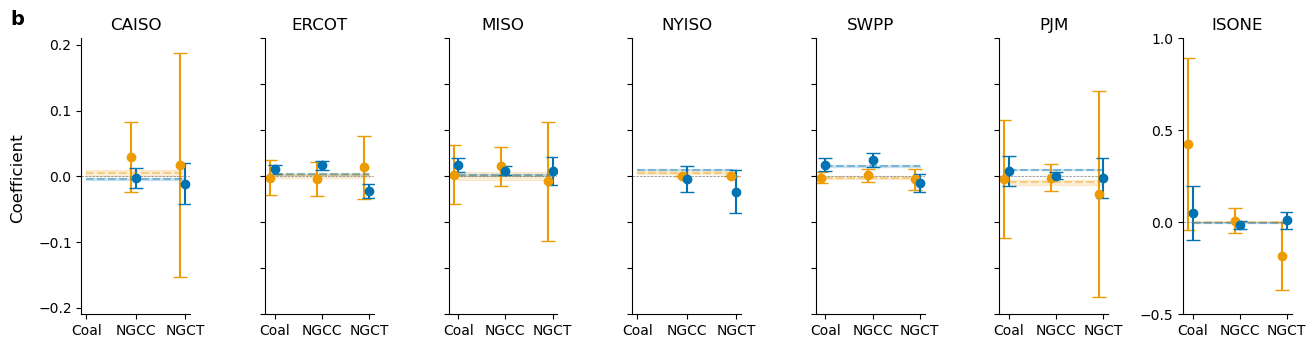

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the desired order of BAs
ordered_bas = ['CAISO', 'ERCOT', 'MISO', 'NYISO', 'SWPP', 'PJM', 'ISONE']

# CO₂ emissions intensity coefficients and standard errors
solar_coefficients_co2 = [0.005, 0.002, 0.001, 0.008, -0.003, -0.013, 0.000]
solar_se_co2 = [0.005, 0.006, 0.008, 0.004, 0.003, 0.006, 0.000]

wind_coefficients_co2 = [-0.004, 0.004, 0.003, 0.014, 0.022, 0.014, -0.002]
wind_se_co2 = [0.002, 0.001, 0.002, 0.001, 0.002, 0.001, 0.002]

# Set up figure
fig, axs = plt.subplots(1, len(ordered_bas), figsize=(13, 3.5), sharey=False)

# Loop over each BA to plot data
for i, ba in enumerate(ordered_bas):
    ax = axs[i]
    ba_data = df_plot[df_plot['BA'] == ba]
    
    # Adjust x positions for better spacing
    x_positions = np.arange(len(fuel_categories))  # Original positions
    x_offsets = [-0.1, 0, 0.1]  # Offsets for solar and wind points
    solar_x = x_positions + x_offsets[0]  # Shift solar points left
    wind_x = x_positions + x_offsets[1]  # Center wind points
    
    # Plot solar coefficients with error bars and caps
    ax.errorbar(solar_x, ba_data['solar_coef'], yerr=ba_data['solar_error'], 
                fmt='o', color='#ee9a01', label='Solar Coef', capsize=5) 

    # Plot wind coefficients with error bars and caps
    ax.errorbar(wind_x, ba_data['wind_coef'], yerr=ba_data['wind_error'], 
                fmt='o', color='#0273b2', label='Wind Coef', capsize=5) 
    
    ax.set_title(ba)

    # Overlay CO₂ EI solar and wind coefficients as dashed lines with shaded regions
    ax.plot(x_positions, [solar_coefficients_co2[i]] * len(fuel_categories), 
            linestyle='--', color='#ee9a01', alpha=0.4)
    ax.fill_between(x_positions, 
                    [solar_coefficients_co2[i] - solar_se_co2[i]] * len(fuel_categories),
                    [solar_coefficients_co2[i] + solar_se_co2[i]] * len(fuel_categories),
                    color='#ee9a01', alpha=0.15)
    
    ax.plot(x_positions, [wind_coefficients_co2[i]] * len(fuel_categories), 
            linestyle='--', color='#0273b2', alpha=0.4)
    ax.fill_between(x_positions, 
                    [wind_coefficients_co2[i] - wind_se_co2[i]] * len(fuel_categories),
                    [wind_coefficients_co2[i] + wind_se_co2[i]] * len(fuel_categories),
                    color='#0273b2', alpha=0.15)
    
    ax.set_xticks(range(len(fuel_categories)))
    ax.set_xticklabels(['Coal', 'NGCC', 'NGCT'], rotation=0)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Reference line at 0
    ax.set_ylim(-0.21, 0.21)  

    if ba == 'ISONE':
        ax.set_ylim(-0.4, 0.9) 
        ax.set_yticks([-0.5, 0, 0.5, 1])  # Show y-ticks and labels for ISONE
    elif ba == 'CAISO':
        ax.set_yticks([ -0.2, -0.1, 0, 0.1, 0.2])  # Show y-ticks and labels for CAISO
        ax.tick_params(axis='y', which='both', labelleft=True)  # Show y-ticks and labels
    else:
        ax.set_yticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])  # Show y-ticks without labels
        ax.tick_params(axis='y', which='both', labelleft=False)  # Hide labels

    # Remove top and right spines
    ax.spines['top'].set_visible(False)  # Remove top spine
    ax.spines['right'].set_visible(False)

# Add ylabel for the entire figure
fig.text(-0.01, 0.5, 'Coefficient', va='center', rotation='vertical', fontsize=12)

# Adjust layout to reduce spacing
plt.subplots_adjust(wspace=1)  # Adjust wspace to reduce the horizontal space between plots

fig.text(-0.01, 0.98, 'b', fontsize=14, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.show()


In [5]:
df_plot

,BA,Fuel Category,solar_coef,solar_error,wind_coef,wind_error
0,PJM,Coal,-0.006090,0.127890,0.010915,0.032510
1,PJM,Gas - Combined cycle,-0.003076,0.029759,0.001605,0.007928
2,PJM,Gas - Combustion turbine,-0.038574,0.224670,-0.004471,0.043550
3,CAISO,Coal,NaN,NaN,NaN,NaN
4,CAISO,Gas - Combined cycle,0.029319,0.053897,-0.002703,0.014969
5,CAISO,Gas - Combustion turbine,0.016644,0.170324,-0.011108,0.031294
6,NYISO,Coal,NaN,NaN,NaN,NaN
7,NYISO,Gas - Combined cycle,0.000000,0.000000,-0.005389,0.027729
8,NYISO,Gas - Combustion turbine,0.000000,0.000000,-0.033617,0.046778
9,SWPP,Coal,-0.002685,0.012954,0.025481,0.013977


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Define paths for each BA's CSV file (assuming files are named as `<BA>_regression.csv` in the current directory)
ba_files = glob.glob('*_generation_regression.csv')
fuel_categories = ['Coal', 'Gas - Combined cycle', 'Gas - Combustion turbine']
bas = [file.split('_')[0] for file in ba_files]  # Extracting BA names from file names

# Define storage for data aggregation
data = []

# Process each BA's file
for file, ba in zip(ba_files, bas):
    df = pd.read_csv(file)
    
    # Filter for specific fuel categories
    df_filtered = df[df['Fuel Category'].isin(fuel_categories)]
    
    # Extract relevant data
    for fuel in fuel_categories:
        df_fuel = df_filtered[df_filtered['Fuel Category'] == fuel]
        
        # Calculate means and errors (standard errors in parentheses) for each category
        solar_coef = df_fuel['solar_generation_mw_coef'].astype(float).mean()
        solar_error = df_fuel['solar_generation_mw'].str.extract(r'\((.*?)\)').astype(float).mean().values[0]

        wind_coef = df_fuel['wind_generation_mw_coef'].astype(float).mean()
        wind_error = df_fuel['wind_generation_mw'].str.extract(r'\((.*?)\)').astype(float).mean().values[0]

        # Store results
        data.append({'BA': ba, 'Fuel Category': fuel, 
                     'solar_coef': solar_coef, 'solar_error': solar_error,
                     'wind_coef': wind_coef, 'wind_error': wind_error})

# Convert aggregated data into DataFrame
df_plot = pd.DataFrame(data)


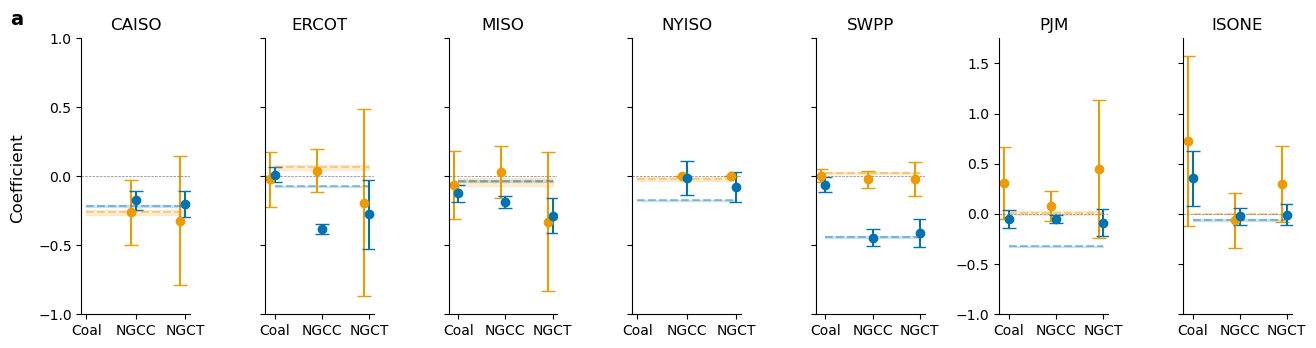

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define the desired order of BAs with PJM and ISONE as the last two
ordered_bas = ['CAISO', 'ERCOT', 'MISO', 'NYISO', 'SWPP', 'PJM', 'ISONE']

# Updated generation coefficients and standard errors
solar_coefficients_gen = [-0.262, 0.064, -0.040, -0.018, 0.023, 0.006, -0.000]
solar_se_gen = [0.020, 0.018, 0.029, 0.014, 0.009, 0.021, 0.000]

wind_coefficients_gen = [-0.215, -0.072, -0.035, -0.175, -0.439, -0.321, -0.061]
wind_se_gen = [0.008, 0.004, 0.009, 0.004, 0.006, 0.005, 0.008]

# Set up figure
fig, axs = plt.subplots(1, len(ordered_bas), figsize=(13, 3.5), sharey=False)

# Loop over each BA to plot data
for i, ba in enumerate(ordered_bas):
    ax = axs[i]
    ba_data = df_plot[df_plot['BA'] == ba]
    
    # Adjust x positions for better spacing
    x_positions = np.arange(len(fuel_categories))  # Original positions
    x_offsets = [-0.1, 0, 0.1]  # Offsets for solar and wind points
    solar_x = x_positions + x_offsets[0]  # Shift solar points left
    wind_x = x_positions + x_offsets[1]  # Center wind points
    
    # Plot solar coefficients with error bars and caps
    ax.errorbar(solar_x, ba_data['solar_coef'], yerr=ba_data['solar_error'], 
                fmt='o', color='#ee9a01', label='Solar Coef', capsize=5) 

    # Plot wind coefficients with error bars and caps
    ax.errorbar(wind_x, ba_data['wind_coef'], yerr=ba_data['wind_error'], 
                fmt='o', color='#0273b2', label='Wind Coef', capsize=5) 
    
    ax.set_title(ba)

    # Overlay generation solar and wind coefficients as dashed lines with shaded regions
    ax.plot(x_positions, [solar_coefficients_gen[i]] * len(fuel_categories), 
            linestyle='--', color='#ee9a01', alpha=0.4)
    ax.fill_between(x_positions, 
                    [solar_coefficients_gen[i] - solar_se_gen[i]] * len(fuel_categories),
                    [solar_coefficients_gen[i] + solar_se_gen[i]] * len(fuel_categories),
                    color='#ee9a01', alpha=0.15)
    
    ax.plot(x_positions, [wind_coefficients_gen[i]] * len(fuel_categories), 
            linestyle='--', color='#0273b2', alpha=0.4)
    ax.fill_between(x_positions, 
                    [wind_coefficients_gen[i] - wind_se_gen[i]] * len(fuel_categories),
                    [wind_coefficients_gen[i] + wind_se_gen[i]] * len(fuel_categories),
                    color='#0273b2', alpha=0.15)
    
    # Set x-ticks and labels
    ax.set_xticks(range(len(fuel_categories)))
    ax.set_xticklabels(['Coal', 'NGCC', 'NGCT'], rotation=0)
    
    # Set y-axis limits based on the BA
    if ba in ['PJM', 'ISONE']:
        ax.set_ylim(-1, 1.75)
    else:
        ax.set_ylim(-1, 1)
    
    # Customize y-ticks for specific BAs
    if ba == 'PJM':
        ax.set_yticks([-1,-0.5, 0, 1, 0.5, 1.5])  # Show y-ticks and labels for ISONE
    elif ba == 'ISONE':
        ax.set_yticks([-1,-0.5, 0, 1, 0.5, 1.5]) # Show y-ticks without labels
        ax.tick_params(axis='y', which='both', labelleft=False)  # Hide labels
    elif ba == 'CAISO':
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])  # Show y-ticks and labels for CAISO
        ax.tick_params(axis='y', which='both', labelleft=True)  # Show y-ticks and labels
    else:
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])  # Show y-ticks without labels
        ax.tick_params(axis='y', which='both', labelleft=False)  # Hide labels

    # Remove top and right spines
    ax.spines['top'].set_visible(False)  # Remove top spine
    ax.spines['right'].set_visible(False)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Reference line at 0

# Add ylabel for the entire figure
fig.text(-0.01, 0.5, 'Coefficient', va='center', rotation='vertical', fontsize=12)

fig.text(-0.01, 0.98, 'a', fontsize=14, fontweight='bold', ha='left', va='top')

# Adjust layout to reduce spacing
plt.subplots_adjust(wspace=1)  # Adjust wspace to reduce the horizontal space between plots

plt.tight_layout()
plt.show()


In [8]:
df_plot

,BA,Fuel Category,solar_coef,solar_error,wind_coef,wind_error
0,ERCOT,Coal,-0.020840,0.198480,0.012980,0.052030
1,ERCOT,Gas - Combined cycle,0.040311,0.154848,-0.381693,0.038183
2,ERCOT,Gas - Combustion turbine,-0.190418,0.676618,-0.275488,0.252076
3,PJM,Coal,0.309433,0.359020,-0.051533,0.093200
4,PJM,Gas - Combined cycle,0.078450,0.151213,-0.048274,0.039767
5,PJM,Gas - Combustion turbine,0.443968,0.686584,-0.090156,0.134400
6,MISO,Coal,-0.061821,0.246766,-0.121395,0.061490
7,MISO,Gas - Combined cycle,0.030619,0.187298,-0.186932,0.045546
8,MISO,Gas - Combustion turbine,-0.327588,0.505318,-0.284733,0.127292
9,ISONE,Coal,0.727450,0.847000,0.353600,0.269600


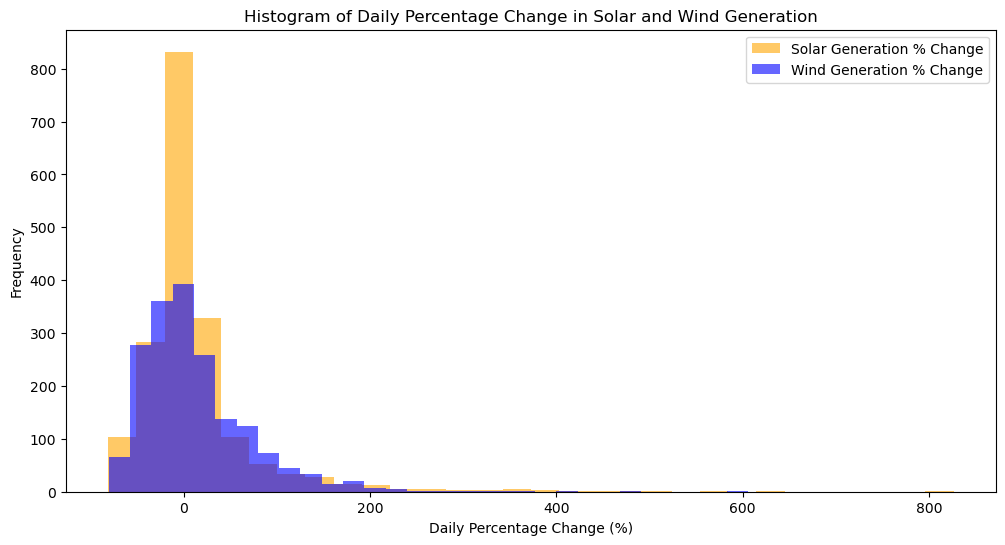

In [226]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df_gen_path = '../data/processed/ERCO.csv'
df_gen = pd.read_csv(df_gen_path)

columns = ['Local time', 'NG: SUN', 'NG: WND', 'D','NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
df_gen = df_gen[columns]

df_gen = df_gen.rename(columns={
    'Local time': 'datetime',
    'D': 'demand_mw',
    'NG: SUN': 'solar_generation_mw',
    'NG: WND': 'wind_generation_mw',
    'NG: COL': 'coal_generation_mw',
    'NG: NG': 'natural_gas_generation_mw',
    'NG: OIL': 'oil_generation_mw',
    'TI': 'imports_mw',
    'NG: WAT': 'hydro_generation_mw',
})

df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
df_gen_D = df_gen.groupby('Date').sum().reset_index()
df_gen_D = df_gen_D.drop(columns=['datetime'])

# Filter between 2019 and 2023
df_gen_D = df_gen_D[(df_gen_D['Date'] >= pd.to_datetime('2019-01-01').date()) & (df_gen_D['Date'] <= pd.to_datetime('2023-12-31').date())]

import pandas as pd
import matplotlib.pyplot as plt

df_gen_d = df_gen_D.copy()

# Sample data loading (assuming df_gen_d is already your DataFrame)
# Convert 'Date' column to datetime format
df_gen_d['Date'] = pd.to_datetime(df_gen_d['Date'])

# Calculate daily percentage change for solar and wind generation
df_gen_d['solar_pct_change'] = df_gen_d['solar_generation_mw'].pct_change() * 100  # Convert to percentage
df_gen_d['wind_pct_change'] = df_gen_d['wind_generation_mw'].pct_change() * 100

# Drop NA values resulting from pct_change
df_gen_d.dropna(subset=['solar_pct_change', 'wind_pct_change'], inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for solar percentage change
plt.hist(df_gen_d['solar_pct_change'], bins=30, alpha=0.6, color='orange', label='Solar Generation % Change')

# Histogram for wind percentage change
plt.hist(df_gen_d['wind_pct_change'], bins=30, alpha=0.6, color='blue', label='Wind Generation % Change')

# Add labels and title
plt.xlabel('Daily Percentage Change (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Percentage Change in Solar and Wind Generation')
plt.legend(loc='upper right')

# Show plot
plt.show()


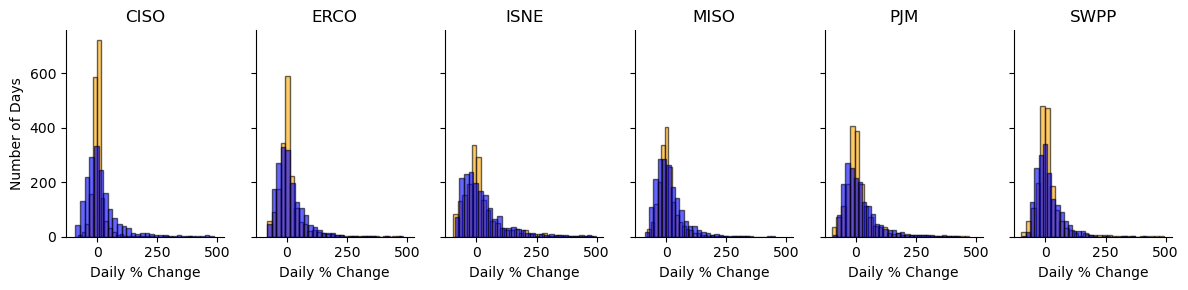

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the list of BAs and file paths
bas = ['CISO', 'ERCO', 'ISNE', 'MISO', 'PJM', 'SWPP']
file_paths = {ba: f'../data/processed/{ba}.csv' for ba in bas}

# Set up the figure for 7 subplots in a single row
fig, axes = plt.subplots(1, 6, figsize=(12, 3), sharey=True, sharex=True)

# Loop through each BA to load data, calculate percentage change, and plot
for i, ba in enumerate(bas):
    # Load data
    df_gen = pd.read_csv(file_paths[ba])
    
    # Filter and rename relevant columns
    columns = ['Local time', 'NG: SUN', 'NG: WND', 'D', 'NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
    df_gen = df_gen[columns]
    df_gen = df_gen.rename(columns={
        'Local time': 'datetime',
        'D': 'demand_mw',
        'NG: SUN': 'solar_generation_mw',
        'NG: WND': 'wind_generation_mw',
        'NG: COL': 'coal_generation_mw',
        'NG: NG': 'natural_gas_generation_mw',
        'NG: OIL': 'oil_generation_mw',
        'TI': 'imports_mw',
        'NG: WAT': 'hydro_generation_mw',
    })
    
    # Convert datetime and calculate daily totals
    df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
    df_gen_D = df_gen.groupby('Date').sum().reset_index()
    df_gen_D = df_gen_D[(df_gen_D['Date'] >= pd.to_datetime('2019-01-01').date()) & (df_gen_D['Date'] <= pd.to_datetime('2023-12-31').date())]
    
    # Calculate daily percentage change and filter values within range
    df_gen_D['solar_pct_change'] = df_gen_D['solar_generation_mw'].pct_change() * 100
    df_gen_D['wind_pct_change'] = df_gen_D['wind_generation_mw'].pct_change() * 100
    df_gen_D = df_gen_D[(df_gen_D['solar_pct_change'].abs() <= 500) & (df_gen_D['wind_pct_change'].abs() <= 500)]  # Clip to ±500%
    
    # Plot histograms for solar and wind percentage changes
    ax = axes[i]
    ax.hist(df_gen_D['solar_pct_change'], bins=30, alpha=0.6, color='orange', label='Solar Generation % Change', edgecolor='black')
    ax.hist(df_gen_D['wind_pct_change'], bins=30, alpha=0.6, color='blue', label='Wind Generation % Change', edgecolor='black')
    
    # Customize plot appearance
    ax.set_title(ba)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label y-axis only for the first subplot
    if i == 0:
        ax.set_ylabel('Number of Days')
    
    # Set consistent x-axis label
    ax.set_xlabel('Daily % Change')

# Adjust layout for consistency and show legend on the first subplot
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust horizontal spacing

# Show plot
plt.show()


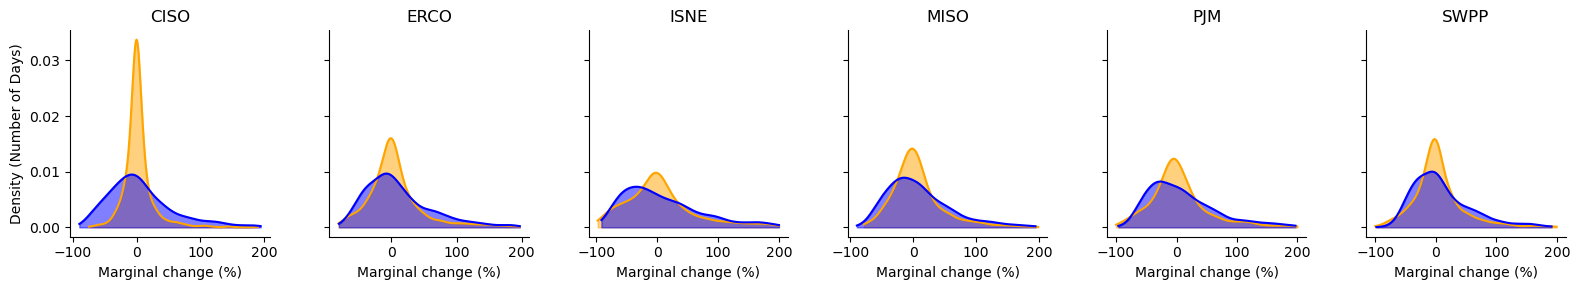

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define the list of BAs and file paths
bas = ['CISO', 'ERCO', 'ISNE', 'MISO', 'PJM', 'SWPP']
file_paths = {ba: f'../data/processed/{ba}.csv' for ba in bas}

# Set up the figure for 6 subplots in a single row
fig, axes = plt.subplots(1, 6, figsize=(16, 3), sharey=True)

# Loop through each BA to load data, calculate percentage change, and plot
for i, ba in enumerate(bas):
    # Load data
    df_gen = pd.read_csv(file_paths[ba])
    
    # Filter and rename relevant columns
    columns = ['Local time', 'NG: SUN', 'NG: WND', 'D', 'NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
    df_gen = df_gen[columns]
    df_gen = df_gen.rename(columns={
        'Local time': 'datetime',
        'D': 'demand_mw',
        'NG: SUN': 'solar_generation_mw',
        'NG: WND': 'wind_generation_mw',
        'NG: COL': 'coal_generation_mw',
        'NG: NG': 'natural_gas_generation_mw',
        'NG: OIL': 'oil_generation_mw',
        'TI': 'imports_mw',
        'NG: WAT': 'hydro_generation_mw',
    })
    
    # Convert datetime and calculate daily totals
    df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
    df_gen_D = df_gen.groupby('Date').sum().reset_index()
    df_gen_D = df_gen_D[(df_gen_D['Date'] >= pd.to_datetime('2019-01-01').date()) & (df_gen_D['Date'] <= pd.to_datetime('2023-12-31').date())]
    
    # Calculate daily percentage change and filter values within range
    df_gen_D['solar_pct_change'] = df_gen_D['solar_generation_mw'].pct_change() * 100
    df_gen_D['wind_pct_change'] = df_gen_D['wind_generation_mw'].pct_change() * 100
    df_gen_D = df_gen_D[(df_gen_D['solar_pct_change'].abs() <= 200) & (df_gen_D['wind_pct_change'].abs() <= 200)]  # Clip to ±500%
    
    # Plot KDE for solar and wind percentage changes
    ax = axes[i]
    solar_data = df_gen_D['solar_pct_change'].dropna()
    wind_data = df_gen_D['wind_pct_change'].dropna()
    
    # Calculate KDE for solar data
    solar_kde = gaussian_kde(solar_data)
    x_solar = np.linspace(solar_data.min(), solar_data.max(), 1000)
    y_solar = solar_kde(x_solar)
    ax.plot(x_solar, y_solar, color='orange', label='Solar Generation % Change')
    ax.fill_between(x_solar, y_solar, color='orange', alpha=0.5)
    
    # Calculate KDE for wind data
    wind_kde = gaussian_kde(wind_data)
    x_wind = np.linspace(wind_data.min(), wind_data.max(), 1000)
    y_wind = wind_kde(x_wind)
    ax.plot(x_wind, y_wind, color='blue', label='Wind Generation % Change')
    ax.fill_between(x_wind, y_wind, color='blue', alpha=0.5)
    
    # Customize plot appearance
    ax.set_title(ba)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label y-axis only for the first subplot
    if i == 0:
        ax.set_ylabel('Density (Number of Days)')
    
    # Set consistent x-axis label
    ax.set_xlabel('Marginal change (%)')

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal spacing  # Add legend on the first subplot

plt.show()


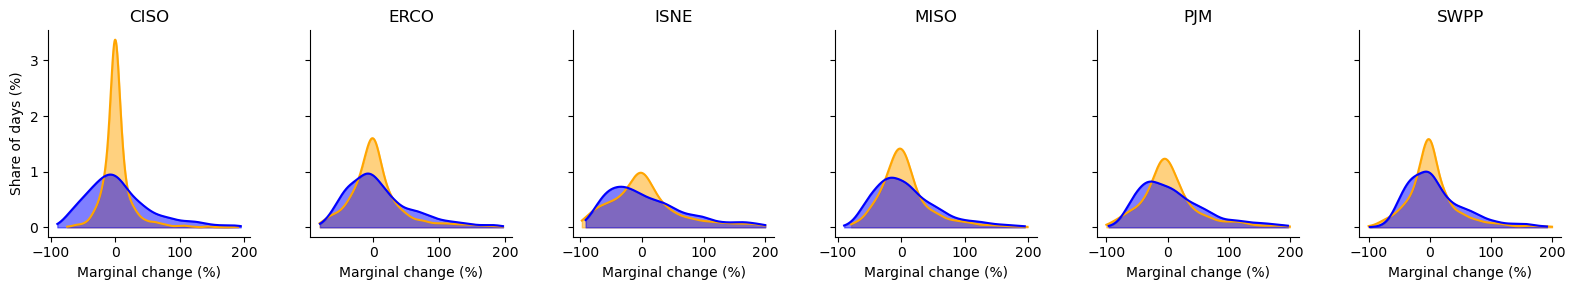

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define the list of BAs and file paths
bas = ['CISO', 'ERCO', 'ISNE', 'MISO', 'PJM', 'SWPP']
file_paths = {ba: f'../data/processed/{ba}.csv' for ba in bas}

# Set up the figure for 6 subplots in a single row
fig, axes = plt.subplots(1, 6, figsize=(16, 3), sharey=True)

# Total number of days over 5 years
total_days = 365 * 5

# Loop through each BA to load data, calculate percentage change, and plot
for i, ba in enumerate(bas):
    # Load data
    df_gen = pd.read_csv(file_paths[ba])
    
    # Filter and rename relevant columns
    columns = ['Local time', 'NG: SUN', 'NG: WND', 'D', 'NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
    df_gen = df_gen[columns]
    df_gen = df_gen.rename(columns={
        'Local time': 'datetime',
        'D': 'demand_mw',
        'NG: SUN': 'solar_generation_mw',
        'NG: WND': 'wind_generation_mw',
        'NG: COL': 'coal_generation_mw',
        'NG: NG': 'natural_gas_generation_mw',
        'NG: OIL': 'oil_generation_mw',
        'TI': 'imports_mw',
        'NG: WAT': 'hydro_generation_mw',
    })
    
    # Convert datetime and calculate daily totals
    df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
    df_gen_D = df_gen.groupby('Date').sum().reset_index()
    df_gen_D = df_gen_D[(df_gen_D['Date'] >= pd.to_datetime('2019-01-01').date()) & (df_gen_D['Date'] <= pd.to_datetime('2023-12-31').date())]
    
    # Calculate daily percentage change and filter values within range
    df_gen_D['solar_pct_change'] = df_gen_D['solar_generation_mw'].pct_change() * 100
    df_gen_D['wind_pct_change'] = df_gen_D['wind_generation_mw'].pct_change() * 100
    df_gen_D = df_gen_D[(df_gen_D['solar_pct_change'].abs() <= 200) & (df_gen_D['wind_pct_change'].abs() <= 200)]  # Clip to ±200%
    
    # Plot KDE for solar and wind percentage changes
    ax = axes[i]
    solar_data = df_gen_D['solar_pct_change'].dropna()
    wind_data = df_gen_D['wind_pct_change'].dropna()
    
    # Calculate KDE for solar data and scale to total number of days
    solar_kde = gaussian_kde(solar_data)
    x_solar = np.linspace(solar_data.min(), solar_data.max(), 1000)
    y_solar = solar_kde(x_solar) * 100  # Scale density by total number of days
    ax.plot(x_solar, y_solar, color='orange', label='Solar Generation % Change')
    ax.fill_between(x_solar, y_solar, color='orange', alpha=0.5)
    
    # Calculate KDE for wind data and scale to total number of days
    wind_kde = gaussian_kde(wind_data)
    x_wind = np.linspace(wind_data.min(), wind_data.max(), 1000)
    y_wind = wind_kde(x_wind) * 100  # Scale density by total number of days
    ax.plot(x_wind, y_wind, color='blue', label='Wind Generation % Change')
    ax.fill_between(x_wind, y_wind, color='blue', alpha=0.5)
    
    # Customize plot appearance
    ax.set_title(ba)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yscale('log')  # Set y-axis to log scale
    
    # Label y-axis only for the first subplot
    if i == 0:
        ax.set_ylabel('Share of days (%)')
    
    # Set consistent x-axis label
    ax.set_xlabel('Marginal change (%)')

# Adjust layout and show plot
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal spacing
#axes[0].legend(loc='upper right')  # Add legend on the first subplot

plt.show()


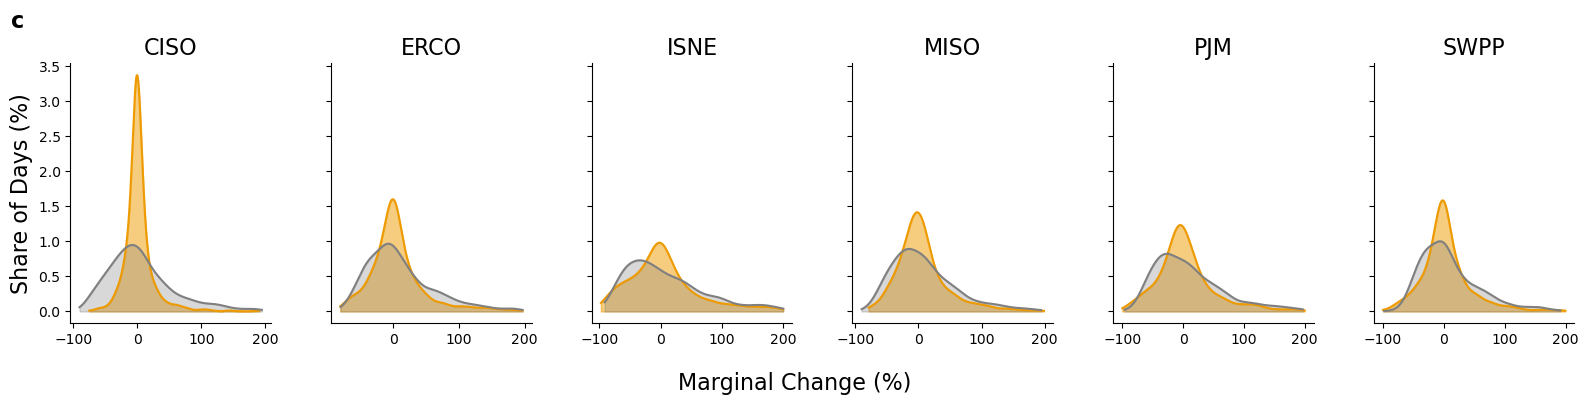

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Define the list of BAs and file paths
bas = ['CISO', 'ERCO', 'ISNE', 'MISO', 'PJM', 'SWPP']
file_paths = {ba: f'../data/processed/{ba}.csv' for ba in bas}

# Set up the figure for 6 subplots in a single row
fig, axes = plt.subplots(1, 6, figsize=(16, 4), sharey=True)

# Total number of days over 5 years
total_days = 365 * 5

# Loop through each BA to load data, calculate percentage change, and plot
for i, ba in enumerate(bas):
    # Load data
    df_gen = pd.read_csv(file_paths[ba])
    
    # Filter and rename relevant columns
    columns = ['Local time', 'NG: SUN', 'NG: WND', 'D', 'NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
    df_gen = df_gen[columns]
    df_gen = df_gen.rename(columns={
        'Local time': 'datetime',
        'D': 'demand_mw',
        'NG: SUN': 'solar_generation_mw',
        'NG: WND': 'wind_generation_mw',
        'NG: COL': 'coal_generation_mw',
        'NG: NG': 'natural_gas_generation_mw',
        'NG: OIL': 'oil_generation_mw',
        'TI': 'imports_mw',
        'NG: WAT': 'hydro_generation_mw',
    })
    
    # Convert datetime and calculate daily totals
    df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
    df_gen_D = df_gen.groupby('Date').sum().reset_index()
    df_gen_D = df_gen_D[(df_gen_D['Date'] >= pd.to_datetime('2019-01-01').date()) & (df_gen_D['Date'] <= pd.to_datetime('2023-12-31').date())]
    
    # Calculate daily percentage change and filter values within range
    df_gen_D['solar_pct_change'] = df_gen_D['solar_generation_mw'].pct_change() * 100
    df_gen_D['wind_pct_change'] = df_gen_D['wind_generation_mw'].pct_change() * 100
    df_gen_D = df_gen_D[(df_gen_D['solar_pct_change'].abs() <= 200) & (df_gen_D['wind_pct_change'].abs() <= 200)]
    
    # Plot KDE for solar and wind percentage changes
    ax = axes[i]
    solar_data = df_gen_D['solar_pct_change'].dropna()
    wind_data = df_gen_D['wind_pct_change'].dropna()
    
    # Calculate KDE for solar data and scale to percentage
    solar_kde = gaussian_kde(solar_data)
    x_solar = np.linspace(solar_data.min(), solar_data.max(), 1000)
    y_solar = solar_kde(x_solar) * 100  # Scale density by total number of days
    ax.plot(x_solar, y_solar, color='#ee9a01', label='Solar Generation % Change')
    ax.fill_between(x_solar, y_solar, color='#ee9a01', alpha=0.5)
    
    # Calculate KDE for wind data and scale to percentage
    wind_kde = gaussian_kde(wind_data)
    x_wind = np.linspace(wind_data.min(), wind_data.max(), 1000)
    y_wind = wind_kde(x_wind) * 100  # Scale density by total number of days
    ax.plot(x_wind, y_wind, color='grey', label='Wind Generation % Change')
    ax.fill_between(x_wind, y_wind, color='grey', alpha=0.3)
    
    # Customize plot appearance
    ax.set_title(ba, fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label y-axis only for the first subplot
    if i == 0:
        ax.set_ylabel('Share of Days (%)', fontsize=16)
    
# Set the single x-axis label
fig.text(0.5, 0.03, 'Marginal Change (%)', ha='center', fontsize=16)

# Set the overall layout and spacing
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(wspace=0.3)

# Add a single legend for the whole figure
#fig.legend(['Solar Generation % Change', 'Wind Generation % Change'], loc='upper center', ncol=2, frameon=False, fontsize=11, bbox_to_anchor=(0.5, 1.05))

fig.text(0.01, 0.98, 'c', fontsize=16, fontweight='bold', ha='left', va='top')

plt.show()


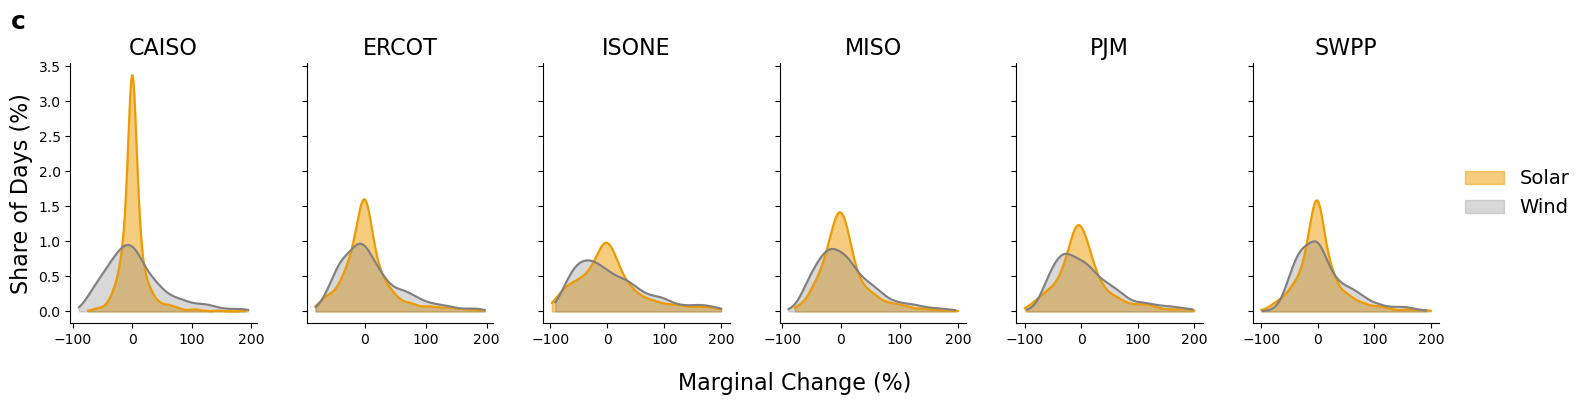

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

# Define the list of BAs and file paths, and titles for each BA
bas = ['CISO', 'ERCO', 'ISNE', 'MISO', 'PJM', 'SWPP']
titles = ['CAISO', 'ERCOT', 'ISONE', 'MISO', 'PJM', 'SWPP']
file_paths = {ba: f'../data/processed/{ba}.csv' for ba in bas}

# Set up the figure for 6 subplots in a single row, with extra space for the legend
fig, axes = plt.subplots(1, 7, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 0.3]})

# Loop through each BA to load data, calculate percentage change, and plot
for i, (ba, title) in enumerate(zip(bas, titles)):
    # Load data
    df_gen = pd.read_csv(file_paths[ba])
    
    # Filter and rename relevant columns
    columns = ['Local time', 'NG: SUN', 'NG: WND', 'D', 'NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
    df_gen = df_gen[columns]
    df_gen = df_gen.rename(columns={
        'Local time': 'datetime',
        'D': 'demand_mw',
        'NG: SUN': 'solar_generation_mw',
        'NG: WND': 'wind_generation_mw',
        'NG: COL': 'coal_generation_mw',
        'NG: NG': 'natural_gas_generation_mw',
        'NG: OIL': 'oil_generation_mw',
        'TI': 'imports_mw',
        'NG: WAT': 'hydro_generation_mw',
    })
    
    # Convert datetime and calculate daily totals
    df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
    df_gen_D = df_gen.groupby('Date').sum().reset_index()
    df_gen_D = df_gen_D[(df_gen_D['Date'] >= pd.to_datetime('2019-01-01').date()) & (df_gen_D['Date'] <= pd.to_datetime('2023-12-31').date())]
    
    # Calculate daily percentage change and filter values within range
    df_gen_D['solar_pct_change'] = df_gen_D['solar_generation_mw'].pct_change() * 100
    df_gen_D['wind_pct_change'] = df_gen_D['wind_generation_mw'].pct_change() * 100
    df_gen_D = df_gen_D[(df_gen_D['solar_pct_change'].abs() <= 200) & (df_gen_D['wind_pct_change'].abs() <= 200)]
    
    # Plot KDE for solar and wind percentage changes
    ax = axes[i]
    solar_data = df_gen_D['solar_pct_change'].dropna()
    wind_data = df_gen_D['wind_pct_change'].dropna()
    
    # Calculate KDE for solar data and scale to percentage
    solar_kde = gaussian_kde(solar_data)
    x_solar = np.linspace(solar_data.min(), solar_data.max(), 1000)
    y_solar = solar_kde(x_solar) * 100  # Scale density by total number of days
    ax.plot(x_solar, y_solar, color='#ee9a01', label='Solar Generation % Change')
    ax.fill_between(x_solar, y_solar, color='#ee9a01', alpha=0.5)
    
    # Calculate KDE for wind data and scale to percentage
    wind_kde = gaussian_kde(wind_data)
    x_wind = np.linspace(wind_data.min(), wind_data.max(), 1000)
    y_wind = wind_kde(x_wind) * 100  # Scale density by total number of days
    ax.plot(x_wind, y_wind, color='grey', label='Wind Generation % Change')
    ax.fill_between(x_wind, y_wind, color='grey', alpha=0.3)
    
    # Customize plot appearance
    ax.set_title(title, fontsize=16)  # Set BA title from the titles list
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Label y-axis only for the first subplot
    if i == 0:
        ax.set_ylabel('Share of Days (%)', fontsize=16)

# Set the single x-axis label
fig.text(0.5, 0.03, 'Marginal Change (%)', ha='center', fontsize=16)

# Add custom legend in the seventh subplot area
legend_ax = axes[-1]
legend_ax.axis('off')  # Hide the seventh subplot's axes

# Define custom legend handles
solar_patch = mpatches.Patch(color='#ee9a01', alpha=0.5, label='Solar')
wind_patch = mpatches.Patch(color='grey', alpha=0.3, label='Wind')
legend_ax.legend(handles=[solar_patch, wind_patch], loc='center', frameon=False, fontsize=14)

# Adjust layout and display
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(wspace=0.3)

# Add panel label 'c'
fig.text(0.01, 0.98, 'c', fontsize=18, fontweight='bold', ha='left', va='top')

plt.show()


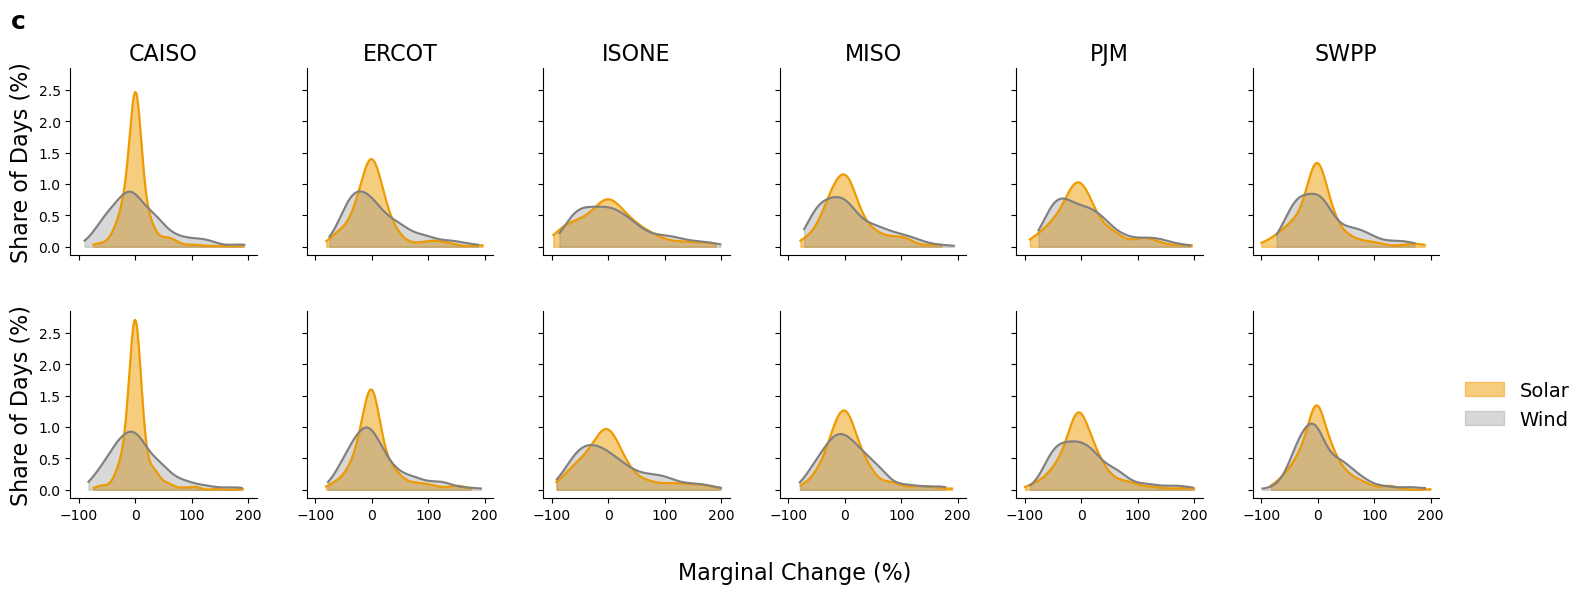

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

# Define the list of BAs and file paths, and titles for each BA
bas = ['CISO', 'ERCO', 'ISNE', 'MISO', 'PJM', 'SWPP']
titles = ['CAISO', 'ERCOT', 'ISONE', 'MISO', 'PJM', 'SWPP']
file_paths = {ba: f'../data/processed/{ba}.csv' for ba in bas}

# Set up the figure for 6 subplots in two rows, with extra space for the legend
fig, axes = plt.subplots(2, 7, figsize=(16, 6), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 0.3]})

# Define date ranges for each row
date_ranges = {'2019': pd.to_datetime(['2019-01-01', '2019-12-31']),
               '2023': pd.to_datetime(['2023-01-01', '2023-12-31'])}

# Loop through each BA to load data, calculate percentage change, and plot
for row, (year, date_range) in enumerate(date_ranges.items()):
    for i, (ba, title) in enumerate(zip(bas, titles)):
        # Load data
        df_gen = pd.read_csv(file_paths[ba])
        
        # Filter and rename relevant columns
        columns = ['Local time', 'NG: SUN', 'NG: WND', 'D', 'NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
        df_gen = df_gen[columns]
        df_gen = df_gen.rename(columns={
            'Local time': 'datetime',
            'D': 'demand_mw',
            'NG: SUN': 'solar_generation_mw',
            'NG: WND': 'wind_generation_mw',
            'NG: COL': 'coal_generation_mw',
            'NG: NG': 'natural_gas_generation_mw',
            'NG: OIL': 'oil_generation_mw',
            'TI': 'imports_mw',
            'NG: WAT': 'hydro_generation_mw',
        })
        
        # Convert datetime and calculate daily totals within specified year range
        df_gen['Date'] = pd.to_datetime(df_gen['datetime']).dt.date
        df_gen_D = df_gen.groupby('Date').sum().reset_index()
        df_gen_D = df_gen_D[(df_gen_D['Date'] >= date_range[0].date()) & (df_gen_D['Date'] <= date_range[1].date())]
        
        # Calculate daily percentage change and filter values within range
        df_gen_D['solar_pct_change'] = df_gen_D['solar_generation_mw'].pct_change() * 100
        df_gen_D['wind_pct_change'] = df_gen_D['wind_generation_mw'].pct_change() * 100
        df_gen_D = df_gen_D[(df_gen_D['solar_pct_change'].abs() <= 300) & (df_gen_D['wind_pct_change'].abs() <= 2300)]
        
        # Plot KDE for solar and wind percentage changes
        ax = axes[row, i]
        solar_data = df_gen_D['solar_pct_change'].dropna()
        wind_data = df_gen_D['wind_pct_change'].dropna()
        
        # Calculate KDE for solar data and scale to percentage
        solar_kde = gaussian_kde(solar_data)
        x_solar = np.linspace(solar_data.min(), solar_data.max(), 1000)
        y_solar = solar_kde(x_solar) * 100  # Scale density by total number of days
        ax.plot(x_solar, y_solar, color='#ee9a01', label='Solar Generation % Change')
        ax.fill_between(x_solar, y_solar, color='#ee9a01', alpha=0.5)
        
        # Calculate KDE for wind data and scale to percentage
        wind_kde = gaussian_kde(wind_data)
        x_wind = np.linspace(wind_data.min(), wind_data.max(), 1000)
        y_wind = wind_kde(x_wind) * 100  # Scale density by total number of days
        ax.plot(x_wind, y_wind, color='grey', label='Wind Generation % Change')
        ax.fill_between(x_wind, y_wind, color='grey', alpha=0.3)
        
        # Customize plot appearance
        if row == 0:
            ax.set_title(title, fontsize=16)  # Set BA title from the titles list
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Label y-axis only for the first plot in each row
        if i == 0:
            ax.set_ylabel('Share of Days (%)', fontsize=16)

# Set the single x-axis label and the legend for the second row
fig.text(0.5, 0.03, 'Marginal Change (%)', ha='center', fontsize=16)

# Add custom legend in the seventh subplot area of the second row
legend_ax = axes[0, -1]
legend_ax.axis('off')  # Hide the seventh subplot's axes
legend_ax = axes[1, -1]
legend_ax.axis('off')  # Hide the seventh subplot's axes

# Define custom legend handles
solar_patch = mpatches.Patch(color='#ee9a01', alpha=0.5, label='Solar')
wind_patch = mpatches.Patch(color='grey', alpha=0.3, label='Wind')
legend_ax.legend(handles=[solar_patch, wind_patch], loc='center', frameon=False, fontsize=14)

# Adjust layout and display
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Add panel label 'c' to the top left of the figure
fig.text(0.01, 0.98, 'c', fontsize=18, fontweight='bold', ha='left', va='top')

plt.show()
